referring for articles:
https://www.sbert.net/

In [1]:
import pandas as pd
import numpy as np
import preprocess
import utilities
import similarities
import parameters
import seaborn as sns
from numpy import dot
from numpy.linalg import norm
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_paths = parameters.data_paths
sim_calculation_type = parameters.sim_calculation_type
all_sentence_embeddings =  parameters.huggingface_embeddings + parameters.openai_embeddings + parameters.google_embeddings

In [4]:
def calculate_within_class(X, y, sim_calculation_type, sim_df):
    
    import ray
    ray.init(num_cpus=3, ignore_reinit_error=True)
    
    @ray.remote
    def run(vecs, sim_calculation_type):
        return similarities.calculate_similarity_within_classes(vecs, sim_calculation_type)

    futures = [run.remote(X.loc[y[y[col]==1].index], sim_calculation_type) for col in y.columns]
    results = ray.get(futures) 
    
    for col, sim in zip(y.columns, results):    
        sim_df.loc[col, col] = sim
    
    ray.shutdown()

    return sim_df

In [5]:
def calculate_within_class(X, y, sim_calculation_type, sim_df):
                 
    max_batch_size = 2_000  
    
    for col in y.columns:   
        
        all_sim = [] 
        
        col_indexes = y[y[col]==1].index
        batch_num = int(len(col_indexes) / max_batch_size) + (len(col_indexes) % max_batch_size > 0)
        
        for batch in np.array_split(col_indexes, batch_num):
            
            all_sim.extend(similarities.calculate_similarity_within_classes(X.loc[batch], sim_calculation_type=None))
        
        sim_df.loc[col, col] = np.mean(all_sim)
        
    return sim_df

In [6]:
def calculate_between_class(X, y, sim_df):
    
    import ray
    ray.init(num_cpus=3,ignore_reinit_error=True)
    
    @ray.remote
    def run(vecs1, vecs2):
        return similarities.calculate_similarity_between_classes(vecs1, vecs2, sim_calculation_type)
    
    futures = [run.remote(X[y[y[col1]==1].index], X[y[y[col2]==1].index]) for col1, col2 in list(combinations(y.columns, 2))]
    results = ray.get(futures) 
    
    for (col1, col2), sim in zip(list(combinations(y.columns, 2)), results):
        sim_df.loc[col1, col2] = sim
    
    ray.shutdown()
    
    return sim_df

In [7]:
def calculate_between_class(X, y, sim_df):
    
    max_batch_size = 2_000
    
    for col1, col2 in list(combinations(y.columns, 2)):
        
        all_sim = [] 
        
        col1_indexes = y[y[col1]==1].index
        col2_indexes = y[y[col2]==1].index
        
        batch_num1 = int(len(col1_indexes) / max_batch_size) + (len(col1_indexes) % max_batch_size > 0)
        batch_num2 = int(len(col2_indexes) / max_batch_size) + (len(col2_indexes) % max_batch_size > 0)
        
        for batch1 in np.array_split(col1_indexes, batch_num1):
            for batch2 in np.array_split(col2_indexes, batch_num2):
                
                all_sim.extend(similarities.calculate_similarity_between_classes(X.loc[batch1], X.loc[batch2], sim_calculation_type=None))
        
        sim_df.loc[col1, col2] = np.mean(all_sim)
        
    return sim_df

In [8]:
def calculate_similarity_matrix(X, y, sim_method='cosine'):
    
    sim_df = pd.DataFrame(index=y.columns, columns=y.columns)
    sim_df = calculate_within_class(X, y, sim_calculation_type, sim_df)
    sim_df = calculate_between_class(X, y, sim_df)
    
    return sim_df

In [9]:
res_file = 'embedding_results_ohsumed.p'

import pickle
results = {}
with open(res_file, 'wb') as f:
    pickle.dump(results, f)

In [10]:
data = 'ohsumed'
path = data_paths[data]

df = utilities.read_data(path)
X = df['text']
y = df.drop(['text'], axis=1)
X = X.apply(preprocess.preprocess_text)

import pickle
with open(res_file, 'rb') as f:
    results = pickle.load(f)

iterate = [i for i in all_sentence_embeddings if i not in results.keys()]
results['failed_embedings'] = []

for embedding_method in tqdm(iterate):
    
    try:
        X_num = utilities.vectorize_data(X, embedding_method)
        sim_df = calculate_similarity_matrix(X_num, y)
        results[embedding_method] = sim_df
        print(embedding_method, ' completed ... ')
    except Exception as e: 
        print(f'! {embedding_method} failed due to {e}... ')
        results['failed_embedings'].append(embedding_method)
    
    with open(res_file, 'wb') as f:
        pickle.dump(results, f)
        
    import torch, gc
    gc.collect()
    torch.cuda.empty_cache()

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

all-mpnet-base-v1  completed ... 


  6%|████▉                                                                       | 2/31 [2:05:23<30:17:11, 3759.71s/it]

all-mpnet-base-v2  completed ... 


 10%|███████▎                                                                    | 3/31 [3:29:04<33:43:12, 4335.45s/it]

all-roberta-large-v1  completed ... 


 13%|█████████▊                                                                  | 4/31 [4:30:06<30:31:24, 4069.80s/it]

all-distilroberta-v1  completed ... 


Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\albert-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 16%|████████████▎                                                               | 5/31 [5:32:35<28:33:24, 3954.00s/it]

albert-base-v2  completed ... 


 19%|██████████████▋                                                             | 6/31 [5:32:36<18:07:28, 2609.96s/it]

! ALBERT-xlarge failed due to 404 Client Error: Not Found for url: https://huggingface.co/api/models/sentence-transformers/ALBERT-xlarge... 


 23%|█████████████████▏                                                          | 7/31 [5:32:37<11:42:46, 1756.95s/it]

! ALBERT-xxlarg failed due to 404 Client Error: Not Found for url: https://huggingface.co/api/models/sentence-transformers/ALBERT-xxlarg... 


 26%|███████████████████▌                                                        | 8/31 [6:33:34<15:05:23, 2361.87s/it]

bert-base-nli-mean-tokens  completed ... 


 29%|██████████████████████                                                      | 9/31 [7:16:36<14:51:14, 2430.67s/it]

distiluse-base-multilingual-cased-v1  completed ... 


 32%|████████████████████████▏                                                  | 10/31 [8:19:24<16:35:14, 2843.55s/it]

multi-qa-mpnet-base-dot-v1  completed ... 


 35%|██████████████████████████▌                                                | 11/31 [9:20:33<17:12:07, 3096.39s/it]

all-distilroberta-v1  completed ... 
all-roberta-large-v1  completed ... 


 39%|████████████████████████████▋                                             | 12/31 [10:45:34<19:33:35, 3706.06s/it]WARNING:root:No sentence-transformers model found with name C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if yo

bert-base-uncased  completed ... 


 45%|█████████████████████████████████▍                                        | 14/31 [12:49:17<17:30:41, 3708.30s/it]

bert-base-nli-mean-tokens  completed ... 
distiluse-base-multilingual-cased-v1  completed ... 


 48%|███████████████████████████████████▊                                      | 15/31 [13:32:41<15:00:06, 3375.39s/it]

distilbert-base-nli-mean-tokens  completed ... 


 52%|██████████████████████████████████████▏                                   | 16/31 [14:34:01<14:26:46, 3467.09s/it]

multi-qa-mpnet-base-dot-v1  completed ... 


 55%|████████████████████████████████████████▌                                 | 17/31 [15:37:04<13:51:12, 3562.29s/it]WARNING:root:No sentence-transformers model found with name C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\nlpaueb_legal-bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\nlpaueb_legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model fr

nlpaueb/legal-bert-base-uncased  completed ... 


 61%|█████████████████████████████████████████████▎                            | 19/31 [17:11:22<10:20:27, 3102.27s/it]

paraphrase-multilingual-MiniLM-L12-v2  completed ... 


 65%|███████████████████████████████████████████████▋                          | 20/31 [18:13:48<10:04:09, 3295.41s/it]

paraphrase-mpnet-base-v2  completed ... 


 68%|██████████████████████████████████████████████████▊                        | 21/31 [18:44:55<7:57:47, 2866.73s/it]

paraphrase-MiniLM-L6-v2  completed ... 


 71%|█████████████████████████████████████████████████████▏                     | 22/31 [19:45:56<7:45:45, 3105.07s/it]

paraphrase-xlm-r-multilingual-v1  completed ... 


Some weights of the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\saibo_legal-roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at C:\Users\IsmailKaraman/.cache\torch\sentence_transformers\saibo_legal-roberta-base and are newly initialized: ['roberta.pool

saibo/legal-roberta-base  completed ... 


 77%|██████████████████████████████████████████████████████████                 | 24/31 [21:53:27<6:46:12, 3481.83s/it]

sentence-t5-large  completed ... 


 81%|████████████████████████████████████████████████████████████▍              | 25/31 [22:19:42<4:50:57, 2909.60s/it]

sentence-transformers/average_word_embeddings_glove.6B.300d  completed ... 
sentence-transformers/average_word_embeddings_glove.840B.300d  completed ... 


 87%|█████████████████████████████████████████████████████████████████▎         | 27/31 [22:46:21<1:57:28, 1762.16s/it]

! text-similarity-babbage-001 failed due to you exceeded your current quota, please check your plan and billing details... 


 90%|███████████████████████████████████████████████████████████████████▋       | 28/31 [22:46:25<1:01:44, 1234.67s/it]

! text-similarity-ada-001 failed due to you exceeded your current quota, please check your plan and billing details... 


 94%|████████████████████████████████████████████████████████████████████████▉     | 29/31 [22:46:29<28:51, 865.66s/it]

! text-similarity-curie-001 failed due to you exceeded your current quota, please check your plan and billing details... 


 97%|███████████████████████████████████████████████████████████████████████████▍  | 30/31 [22:46:34<10:07, 607.28s/it]

! text-similarity-davinci-001 failed due to you exceeded your current quota, please check your plan and billing details... 
universal-sentence-encoder  completed ... 


100%|█████████████████████████████████████████████████████████████████████████████| 31/31 [23:29:31<00:00, 2728.10s/it]


In [11]:
stop

NameError: name 'stop' is not defined

In [13]:
results['failed_embedings']

['ALBERT-xlarge',
 'ALBERT-xxlarg',
 'text-similarity-babbage-001',
 'text-similarity-ada-001',
 'text-similarity-curie-001',
 'text-similarity-davinci-001']

In [14]:
import pickle
with open(res_file, 'rb') as f:
    results_opp115 = pickle.load(f)
results.pop('failed_embedings')

['ALBERT-xlarge',
 'ALBERT-xxlarg',
 'text-similarity-babbage-001',
 'text-similarity-ada-001',
 'text-similarity-curie-001',
 'text-similarity-davinci-001']

In [19]:
def calculate_matrix_score(sim_df):
    scores = []
    for col in sim_df.columns:
        scores.append((sim_df.loc[col, col] - sim_df.loc[col].drop(col).max())/sim_df.loc[col, col])
    return scores

best:
'paraphrase-MiniLM-L6-v2'

In [34]:
removed = ['stsb-roberta-large',
           'albert-base-v2',
           'bert-base-nli-mean-tokens',
           'bert-base-uncased',
           'distilbert-base-nli-mean-tokens',
           'nlpaueb/legal-bert-base-uncased',
           'saibo/legal-roberta-base',
           'sentence-t5-large',
           'sentence-transformers/average_word_embeddings_glove.6B.300d',
           'sentence-transformers/average_word_embeddings_glove.840B.300d',
           'distiluse-base-multilingual-cased-v1',
           'multi-qa-mpnet-base-dot-v1',
           'paraphrase-mpnet-base-v2',
           'paraphrase-multilingual-MiniLM-L12-v2',
           'paraphrase-MiniLM-L6-v2',
           'paraphrase-xlm-r-multilingual-v1',
           'universal-sentence-encoder'
          ]

In [35]:
res = results.copy()
finel_res = {v:k for v, k in res.items() if v not in removed}

In [36]:
for embedding, sim_df in finel_res.items():
    scores = calculate_matrix_score(sim_df)
    scores = scores[:-1]
    print(f'{embedding} --- max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

all-MiniLM-L6-v2 --- max: 0.59, min: 0.14, avg: 0.31
all-MiniLM-L12-v2 --- max: 0.62, min: 0.16, avg: 0.34
all-mpnet-base-v1 --- max: 0.59, min: 0.20, avg: 0.36
all-mpnet-base-v2 --- max: 0.54, min: 0.16, avg: 0.32
all-roberta-large-v1 --- max: 0.52, min: 0.16, avg: 0.29
all-distilroberta-v1 --- max: 0.54, min: 0.12, avg: 0.28


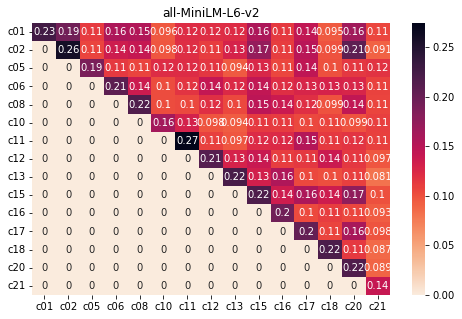

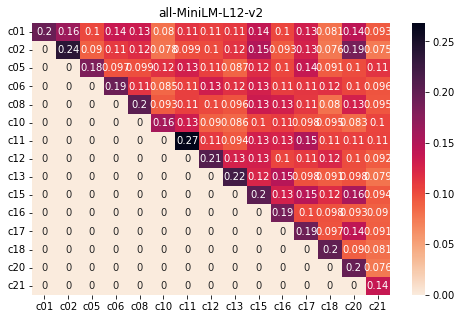

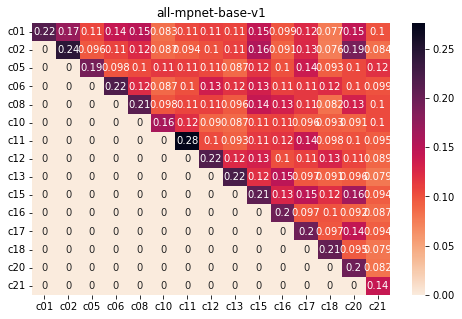

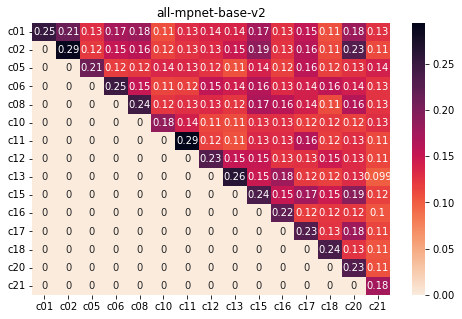

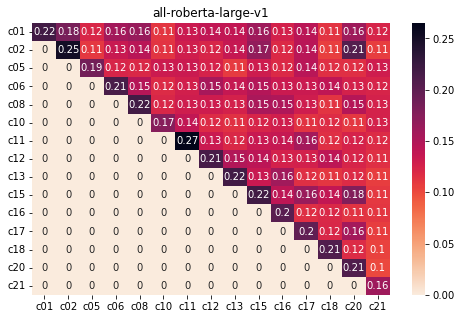

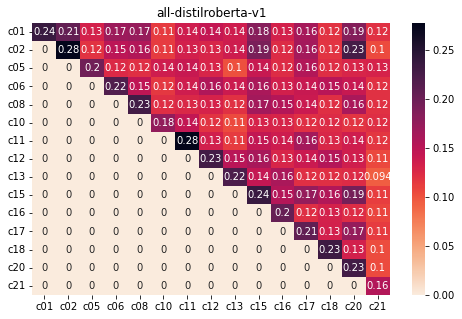

In [37]:
i = 0
for embedding, sim_df in finel_res.items():
    
    plt.figure(i, figsize=(8,5))
    plt.title(f'{embedding}')
    sns.heatmap(sim_df.fillna(0), annot=True,
    xticklabels=sim_df.columns,
    yticklabels=sim_df.columns, cmap="rocket_r")
    

    plt.show()
    i+=1

In [38]:
finel_res.keys()

dict_keys(['all-MiniLM-L6-v2', 'all-MiniLM-L12-v2', 'all-mpnet-base-v1', 'all-mpnet-base-v2', 'all-roberta-large-v1', 'all-distilroberta-v1'])